In [468]:
from datetime import datetime, timedelta
from meteostat import Point, Hourly
import matplotlib.pyplot as plt
import polars as pl
import os, json

In [469]:
PATH = os.getcwd()
time_format = '%Y-%m-%dT%H:%M:%S'

In [470]:
def print_df(df: pl.DataFrame, sort_by: str, n:int):
    with pl.Config() as cfg:
        cfg.set_tbl_cols(-1)
        cfg.set_tbl_width_chars(1000)
        cfg.set_tbl_rows(-1)
        print(df.sort(by=sort_by, descending=True).head(n))

In [471]:
# date range of simulation
from_date = datetime(year=2023, month=6, day=1, hour=0, minute=0, second=0)
to_date = from_date + timedelta(days=7)

In [472]:
# load data frames
topology = 'S_1412610_T_1412615'
topology_df = pl.read_parquet(os.path.join(PATH,"../data/silver/",topology)).sort(by='fromTime', descending=False)
valuta_df = pl.read_parquet(os.path.join(PATH,"../data/raw/price/",'euro_2_nok_valuta_2023-03-01_2023-09-02')).sort(by='timestamp', descending=False)
spot_df = pl.read_parquet(os.path.join(PATH,"../data/raw/price/",'historic_2023-03-01_2023-09-02')).sort(by='Timestamp', descending=False)

In [473]:
# determine the area for price code
features_df = pl.read_parquet(os.path.join(PATH,"../data/silver/features"))
price_area = features_df.filter(pl.col('topology')==topology).select(pl.col('price_area').first()).item()

In [474]:
# determine the latitude and longitude
latitude = features_df.filter(pl.col('topology')==topology).select(pl.col('latitude').first()).item()
longitude = features_df.filter(pl.col('topology')==topology).select(pl.col('longitude').first()).item()

In [475]:
# get data, valuta and spot for date range
topology_df = (topology_df.filter(pl.col('fromTime').is_between(from_date, to_date)))
valuta_df = (valuta_df.filter(pl.col('timestamp').is_between(from_date, to_date)))
spot_df = (spot_df.filter(pl.col('Timestamp').is_between(from_date, to_date)))

In [476]:
# get weather data from meteostat
location = Point(lat=latitude, lon=longitude, alt=0)
weather_df = pl.DataFrame()._from_pandas(Hourly(loc=location, start=from_date, end=to_date).fetch().reset_index().rename(columns={"time":"timestamp"})	)

In [477]:
# calculator to convert area Euro/MWh to NOK/kWh
def exhange_calculator(exchange: pl.DataFrame, price: pl.DataFrame):
    return (price.with_columns(pl.col('Timestamp')
                               .cast(pl.Datetime())).rename({'Timestamp':'timestamp'})
            .join(exchange, on='timestamp', validate='1:1')
            .with_columns((pl.col('NO1')*pl.col('nok_euro')/1000).alias('NO1'),
                          (pl.col('NO2')*pl.col('nok_euro')/1000).alias('NO2'),
                          (pl.col('NO3')*pl.col('nok_euro')/1000).alias('NO3'),
                          (pl.col('NO4')*pl.col('nok_euro')/1000).alias('NO4'),
                          (pl.col('NO5')*pl.col('nok_euro')/1000).alias('NO5')
                          ).select(['timestamp','NO1','NO2','NO3','NO4','NO5']))

In [478]:
price_df = exhange_calculator(exchange=valuta_df, price=spot_df)

In [479]:
# limit
prod_limit_kwh = 70
load_limit_kwh = 70

# plot aggregated neighborhood over week
ami_cnt = topology_df.n_unique(subset='meteringPointId')

# calculate aggregated and average of columns
df = (topology_df.sort(by=['fromTime']).group_by_dynamic('fromTime', every='1h').agg(
    pl.col('p_load_kwh').sum().alias('p_load_sum_kwh'),
    (pl.col('p_load_kwh').sum()/ami_cnt).alias('p_load_avg_kwh'),
    pl.col('p_prod_kwh').sum().alias('p_prod_sum_kwh'),
    (pl.col('p_prod_kwh').sum()/ami_cnt).alias('p_prod_avg_kwh'),
    (pl.col('p_prod_kwh')-pl.col('p_load_kwh')).sum().alias('p_export_sum_kwh'),
    ((pl.col('p_prod_kwh')-pl.col('p_load_kwh')).sum()/ami_cnt).alias('p_export_avg_kwh')
).with_columns(load_limit=pl.lit(load_limit_kwh), prod_limit=pl.lit(prod_limit_kwh))).with_columns(
    pl.when(pl.col('load_limit')<pl.col('p_load_sum_kwh'))
    .then(pl.lit(load_limit_kwh))
    .otherwise(pl.col('p_load_sum_kwh'))
    .alias('req_load_kwh'),
    pl.when(pl.col('prod_limit')<pl.col('p_prod_sum_kwh'))
    .then(pl.lit(prod_limit_kwh))
    .otherwise(pl.col('p_prod_sum_kwh'))
    .alias('req_prod_kwh')
).with_columns(pl.when(pl.col('req_load_kwh')>pl.col('p_load_sum_kwh'))
               .then(pl.lit(0))
               .otherwise(pl.col('p_load_sum_kwh')-pl.col('req_load_kwh')).alias('shave_load_by_kwh'),
               pl.when(pl.col('req_prod_kwh')>pl.col('p_prod_sum_kwh'))
               .then(pl.lit(0))
               .otherwise(pl.col('p_prod_sum_kwh')-pl.col('req_prod_kwh')).alias('shave_prod_by_kwh')
               )

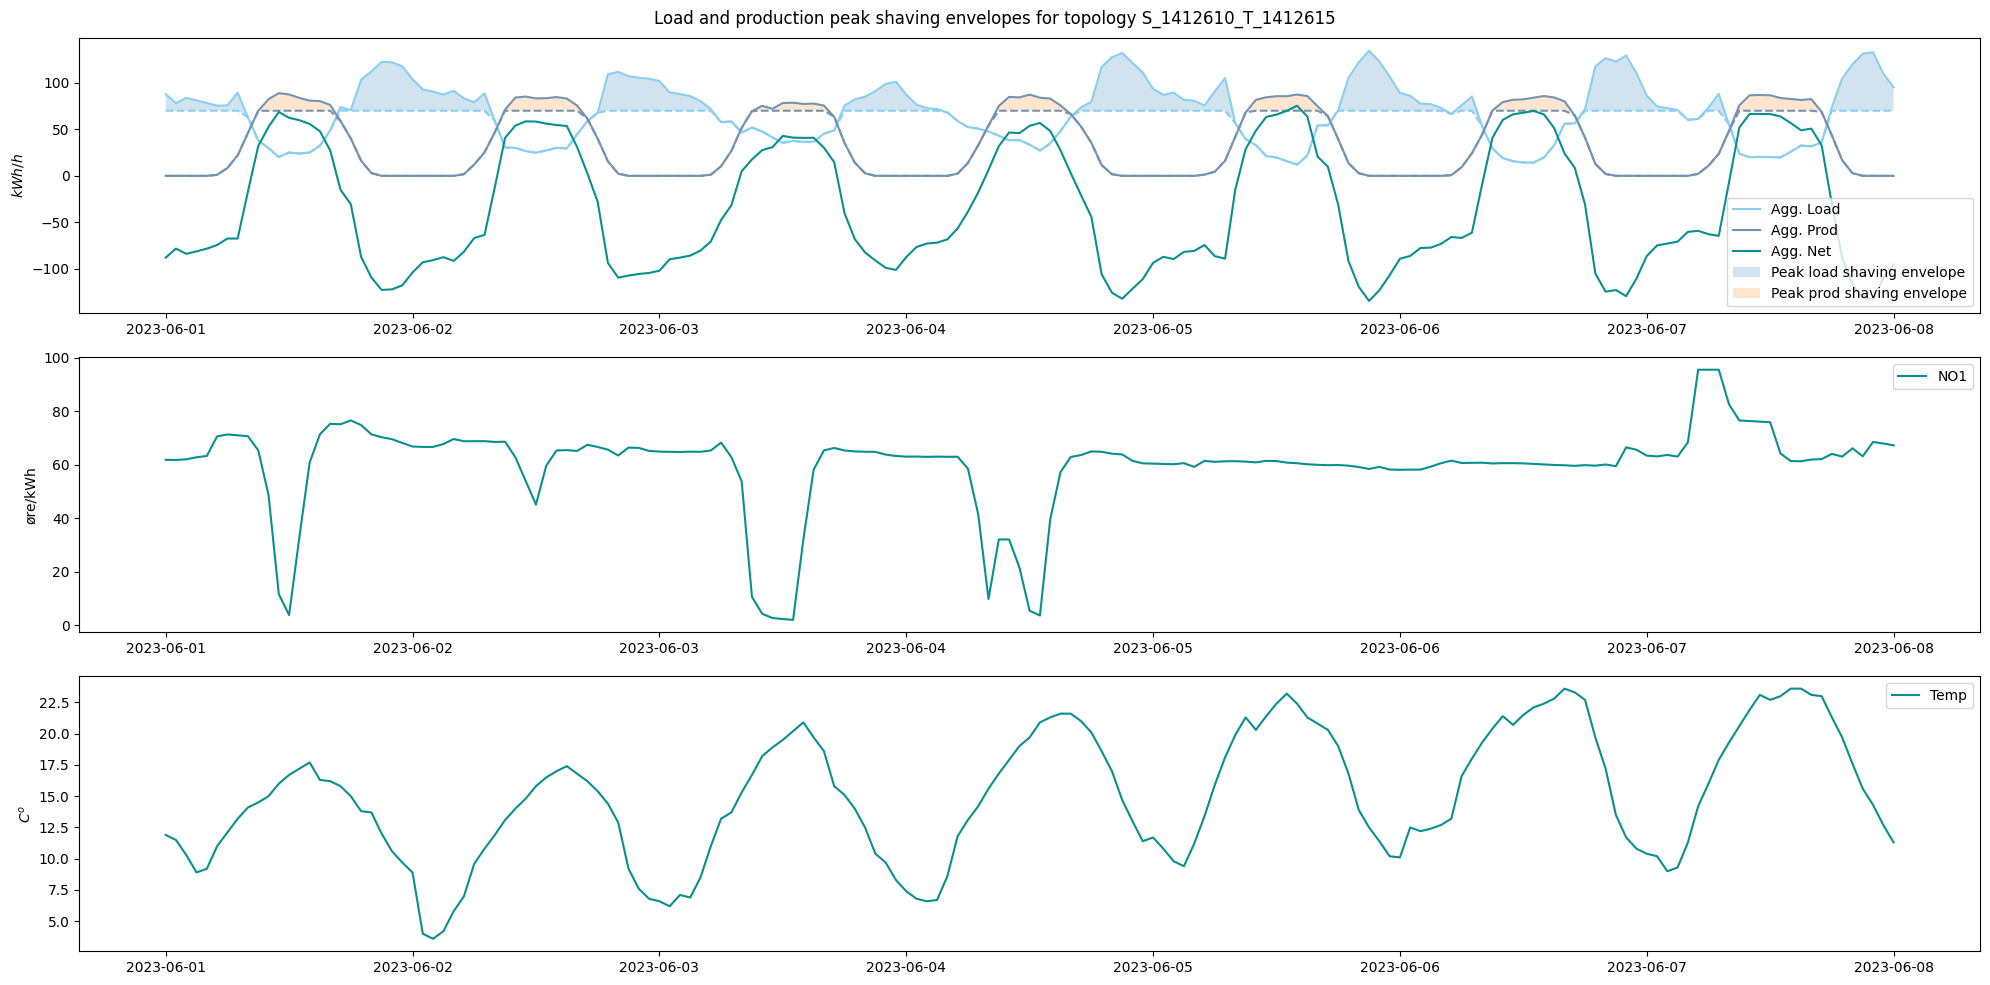

In [480]:
fig, ax = plt.subplots(3,1, figsize=(20,10))

ax[0].plot(df['fromTime'], df['p_load_sum_kwh'], color='#89CFF0', label='Agg. Load')
ax[0].plot(df['fromTime'], df['req_load_kwh'], color='#89CFF0', linestyle='dashed')
ax[0].plot(df['fromTime'], df['p_prod_sum_kwh'], color='#7393B3', label='Agg. Prod')
ax[0].plot(df['fromTime'], df['req_prod_kwh'], color='#7393B3', linestyle='dashed')
ax[0].plot(df['fromTime'], df['p_export_sum_kwh'], color='#088F8F', label='Agg. Net')

ax[0].fill_between(df['fromTime'], df['p_load_sum_kwh'], df['req_load_kwh'], alpha=0.2, label='Peak load shaving envelope')
ax[0].fill_between(df['fromTime'], df['p_prod_sum_kwh'], df['req_prod_kwh'], alpha=0.2, label='Peak prod shaving envelope')
ax[0].set_ylabel('$kWh/h$')
ax[0].legend()

ax[1].plot(price_df['timestamp'], price_df[price_area]*100, color='#088F8F', label=f'{price_area}')
ax[1].set_ylabel('øre/kWh')
ax[1].legend()

ax[2].plot(weather_df['timestamp'], weather_df['temp'], color='#088F8F', label='Temp')
ax[2].set_ylabel('$C^o$')
ax[2].legend()

plt.suptitle(f'Load and production peak shaving envelopes for topology {topology}')
fig.tight_layout()

In [481]:
df_envelope=df.select(['fromTime', 'shave_load_by_kwh','shave_prod_by_kwh'])
df_envelope = df_envelope.with_columns(pl.col('fromTime').dt.strftime(time_format).alias('from_time'),
                                       (pl.col('fromTime')+timedelta(hours=1)).dt.strftime(time_format).alias('to_time')
                                       ).select(['from_time','to_time','shave_load_by_kwh','shave_prod_by_kwh']).sort(by='from_time', descending=False)
print(df_envelope)
with open('energy_envelope.json', 'a+') as fp:
    df_envelope.to_pandas().to_json(fp)

shape: (169, 4)
┌─────────────────────┬─────────────────────┬───────────────────┬───────────────────┐
│ from_time           ┆ to_time             ┆ shave_load_by_kwh ┆ shave_prod_by_kwh │
│ ---                 ┆ ---                 ┆ ---               ┆ ---               │
│ str                 ┆ str                 ┆ f64               ┆ f64               │
╞═════════════════════╪═════════════════════╪═══════════════════╪═══════════════════╡
│ 2023-06-01T00:00:00 ┆ 2023-06-01T01:00:00 ┆ 17.886            ┆ 0.0               │
│ 2023-06-01T01:00:00 ┆ 2023-06-01T02:00:00 ┆ 8.230667          ┆ 0.0               │
│ 2023-06-01T02:00:00 ┆ 2023-06-01T03:00:00 ┆ 13.826333         ┆ 0.0               │
│ 2023-06-01T03:00:00 ┆ 2023-06-01T04:00:00 ┆ 11.220333         ┆ 0.0               │
│ …                   ┆ …                   ┆ …                 ┆ …                 │
│ 2023-06-07T21:00:00 ┆ 2023-06-07T22:00:00 ┆ 61.349214         ┆ 0.0               │
│ 2023-06-07T22:00:00 ┆ 2023-06-07T23:

In [482]:
with open('energy_envelope.json','w+') as fp:
    json.dump([row for row in df_envelope.iter_rows(named=True)],fp)

In [483]:
valuta_df.columns

['timestamp', 'nok_euro']

In [484]:
spot_df

Timestamp,NO1,NO2,NO3,NO4,NO5
datetime[ms],f64,f64,f64,f64,f64
2023-06-01 00:00:00,51.65,57.15,0.01,0.01,51.65
2023-06-01 01:00:00,51.59,59.64,0.08,0.08,51.59
2023-06-01 02:00:00,51.81,62.42,1.35,1.35,51.81
2023-06-01 03:00:00,52.44,64.27,2.07,2.07,52.44
2023-06-01 04:00:00,52.85,68.55,3.97,3.97,52.85
2023-06-01 05:00:00,58.97,68.85,7.45,7.45,58.97
2023-06-01 06:00:00,59.58,69.51,9.23,9.23,59.58
2023-06-01 07:00:00,59.32,69.36,8.6,8.6,59.32
2023-06-01 08:00:00,59.02,65.69,7.87,7.87,59.02
